In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles,make_moons
from sklearn.neighbors import KernelDensity
from gsw.gsw import GSW
import torch
import torch.optim as optim

In [2]:
device=torch.device('cpu')

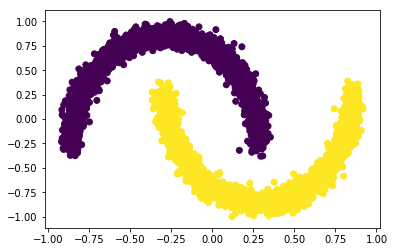

In [3]:
# X,Y=make_circles(5000,noise=.05,factor=.4)
X,Y=make_moons(5000,noise=.05)
X[:,1]*=2
X-=X.mean(0)[np.newaxis,:]
X/=abs(X).max()
Zback=X.copy()
plt.scatter(X[:,0],X[:,1],c=Y)
plt.show()

In [4]:
gridx,gridy=np.meshgrid(np.linspace(-1.2,1.2,num=100),np.linspace(-1.2,1.2,num=100))
gridvec = np.concatenate((np.reshape(gridx,(10000,1)),np.reshape(gridy,(10000,1))),1)

In [5]:
z1 = X[Y==0].copy()
z2 = X[Y==1].copy()

kde1=KernelDensity(bandwidth=1e-1).fit(z1)
Z1=np.exp(kde1.score_samples(gridvec)).reshape((100,100))
kde2=KernelDensity(bandwidth=1e-1).fit(z2)
Z2=np.exp(kde2.score_samples(gridvec)).reshape((100,100))

z1=z1[:100,...]
z2=z2[:100,...]

([<matplotlib.axis.YTick at 0x7f3e7095fa10>,
 <a list of 3 Text yticklabel objects>)

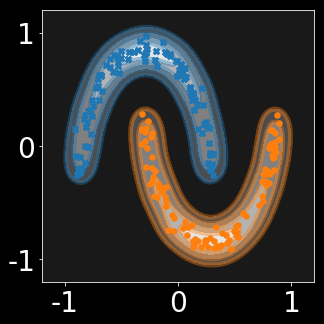

In [6]:
plt.style.use('dark_background')
fig=plt.figure(figsize=(5,5))

plt.contourf(gridx, gridy,Z1+Z2,5,cmap='gray')
plt.contour(gridx, gridy,Z1,5, colors='#1f77b4',linewidths=5,alpha=.4)
plt.contour(gridx, gridy,Z2,5, colors='#ff7f0e',linewidths=5,alpha=.4)

plt.scatter(z1[:,0],z1[:,1],marker='X',c='#1f77b4',s=40)
plt.scatter(z2[:,0],z2[:,1],marker='o',c='#ff7f0e',s=30)

plt.axis('square')
plt.xticks([-1,0,1],[-1,0,1],fontsize=28)
plt.yticks([-1,0,1],[-1,0,1],fontsize=28)

In [7]:
import torch.optim as optim

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    """ MNIST Encoder from Original Paper's Keras based Implementation.
        Args:
            init_num_filters (int): initial number of filters from encoder image channels
            lrelu_slope (float): positive number indicating LeakyReLU negative slope
            inter_fc_dim (int): intermediate fully connected dimensionality prior to embedding layer
            embedding_dim (int): embedding dimensionality
    """
    def __init__(self, din=2,dout=10, num_filters=32, depth=3,slope=.01,activation='leakyReLU'):
        super(MLP, self).__init__()
        self.din=din
        self.dout=dout
        self.init_num_filters = num_filters
        self.depth=depth

        self.features = nn.Sequential()
        
        for i in range(self.depth):
            if i==0:
                self.features.add_module('linear%02d'%(i+1),nn.Linear(self.din,self.init_num_filters))        
            else:
                self.features.add_module('linear%02d'%(i+1),nn.Linear(self.init_num_filters,self.init_num_filters))
            
            if activation=='leakyReLU':
                self.features.add_module('activation%02d'%(i+1),nn.LeakyReLU(negative_slope=slope,inplace=False))
            elif activation=='ReLU':
                self.features.add_module('activation%02d'%(i+1),nn.ReLU(inplace=False))
            elif activation=='Sigmoid':
                self.features.add_module('activation%02d'%(i+1),nn.Sigmoid())
            elif activation=='TanH':
                self.features.add_module('activation%02d'%(i+1),nn.Tanh())
            else: 
                raise Exception('Activation not implemented!')
        self.features.add_module('pool',nn.MaxPool1d(2,stride=2,ceil_mode=False))    
        self.features.add_module('linear%02d'%(i+2),nn.Linear(self.init_num_filters//2,self.dout))
    
    def forward(self, x):
        self.results = []
        for ii,model in enumerate(self.features):
            if isinstance(model,nn.MaxPool1d):
                x = model(x.unsqueeze(1))
                x = x.squeeze()
            else:
                x = model(x)                  
            self.results.append(x)
        return x
    
    def init_weights(self,m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    
    def reset(self):
        self.features.apply(self.init_weights)

MLP(
  (features): Sequential(
    (linear01): Linear(in_features=2, out_features=4, bias=True)
    (activation01): Sigmoid()
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (linear02): Linear(in_features=2, out_features=2, bias=True)
  )
)


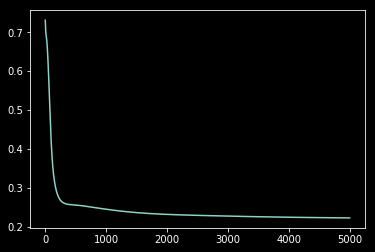

In [43]:
# Train the network

z1trch=torch.from_numpy(z1).type(torch.FloatTensor)
z2trch=torch.from_numpy(z2).type(torch.FloatTensor)

iterations=5000
num_filters=4
model=MLP(din=2,dout=2,num_filters=num_filters,depth=1,slope=.1,activation='Sigmoid')
print(model)
optimizer=optim.Adam(model.parameters(),lr=1e-2)
total_loss=np.zeros((iterations,))
criterion=torch.nn.CrossEntropyLoss()

xin=torch.cat([z1trch,z2trch])
yin=torch.cat([torch.zeros((z1trch.shape[0])),
               torch.ones((z2trch.shape[0]))]).type(torch.LongTensor)

for i in range(iterations):
    optimizer.zero_grad()
    z=model(xin)
    loss=criterion(z,yin)
    total_loss[i]=loss.item()
    loss.backward()
    optimizer.step()

plt.plot(total_loss)
plt.show()

Text(0.5, 0, '$t$')

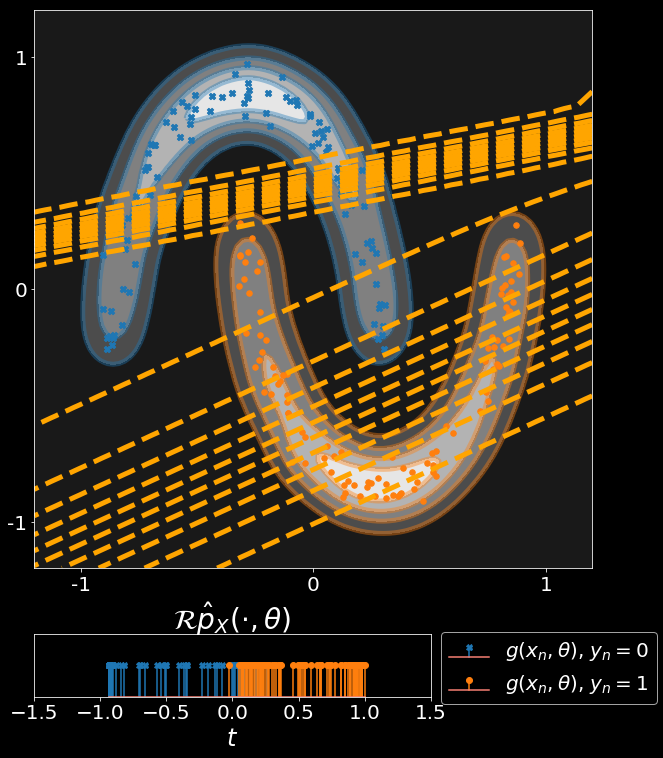

In [42]:
plt.style.use('dark_background')
N=100
l=1.
t=np.linspace(-1.2,1.2,101)

fig=plt.figure(figsize=(10,15))
grid = plt.GridSpec(7,7, wspace=.1, hspace=1.)

plt.subplot(grid[:5,:])
plt.contourf(gridx, gridy,Z1+Z2,5,cmap='gray')

plt.contour(gridx, gridy,Z1,5, colors='#1f77b4',linewidths=5,alpha=.4)
plt.contour(gridx, gridy,Z2,5, colors='#ff7f0e',linewidths=5,alpha=.4)


fgridvec=model(torch.from_numpy(gridvec).type(torch.FloatTensor))[:,1].reshape((100,100))
fgridvec=fgridvec.detach().cpu().numpy()
plt.contour(gridx, gridy,
            fgridvec,
            20, colors='orange',linewidths=5,linestyles='--')

plt.scatter(z1[:,0],z1[:,1],marker='X',c='#1f77b4',s=40)
plt.scatter(z2[:,0],z2[:,1],marker='o',c='#ff7f0e',s=30)


plt.axis('square')
plt.xticks([-1,0,1],[-1,0,1],fontsize=20)
plt.yticks([-1,0,1],[-1,0,1],fontsize=20)



z1proj=model(z1trch)[:,1].detach().cpu().numpy()
z2proj=model(z2trch)[:,1].detach().cpu().numpy()

mtemp=z1proj.max()
mtemp=max(z2proj.max(),mtemp)

z1proj/=mtemp
z2proj/=mtemp

plt.subplot(grid[5,:-2])

markerline, stemlines, baseline = plt.stem(z1proj,np.ones_like(z1proj)/float(N),markerfmt='X',linefmt='#1f77b4')
plt.setp(markerline, 'color', '#1f77b4')
markerline, stemlines, baseline = plt.stem(z2proj,np.ones_like(z2proj)/float(N),markerfmt='o',linefmt='#ff7f0e')
plt.setp(markerline, 'color', '#ff7f0e')

plt.xlim([-1.5,1.5])
plt.ylim([0,.02])
plt.xticks(fontsize=20)
plt.yticks([])
plt.title(r'$\mathcal{R}\hat{p}_X(\cdot,\theta)$',fontsize=28)
plt.legend([r'$g(x_n,\theta)$, $y_n=0$',r'$g(x_n,\theta)$, $y_n=1$'],
           fontsize=20,bbox_to_anchor=(1.0, 1.2))
plt.xlabel(r'$t$',fontsize=24)

[Text(0, 0, '-1'), Text(0, 0, '0'), Text(0, 0, '1')]

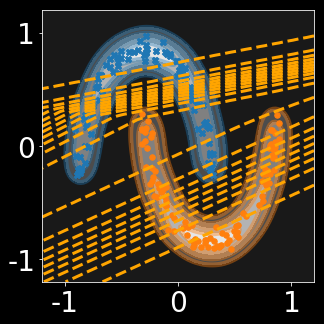

In [12]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.contourf(gridx, gridy,Z1+Z2,5,cmap='gray')

ax.contour(gridx, gridy,Z1,5, colors='#1f77b4',linewidths=5,alpha=.4)
ax.contour(gridx, gridy,Z2,5, colors='#ff7f0e',linewidths=5,alpha=.4)


fgridvec=model(torch.from_numpy(gridvec).type(torch.FloatTensor))[:,1].reshape((100,100))
fgridvec=fgridvec.detach().cpu().numpy()
ax.contour(gridx, gridy,
            fgridvec,
            20, colors='orange',linewidths=3,linestyles='--')

ax.scatter(z1[:,0],z1[:,1],marker='X',c='#1f77b4',s=40)
ax.scatter(z2[:,0],z2[:,1],marker='o',c='#ff7f0e',s=30)


ax.axis('square')
ax.set_xticks([-1,0,1])
ax.set_xticklabels([-1,0,1],fontsize=28)
ax.set_yticks([-1,0,1])
ax.set_yticklabels([-1,0,1],fontsize=28)


In [13]:
ztemp=model(torch.from_numpy(Zback).type(torch.FloatTensor).to(device)).detach().cpu().numpy()
z1proj=ztemp[np.argwhere(Y==0).squeeze()][:,1]
z2proj=ztemp[np.argwhere(Y==1).squeeze()][:,1]

mtemp=z1proj.max()
mtemp=max(z2proj.max(),mtemp)

z1proj/=mtemp
z2proj/=mtemp


kz1=KernelDensity(bandwidth=.1).fit(z1proj[:,np.newaxis])
kz2=KernelDensity(bandwidth=.1).fit(z2proj[:,np.newaxis])

Text(0.5, 0, '$t$')

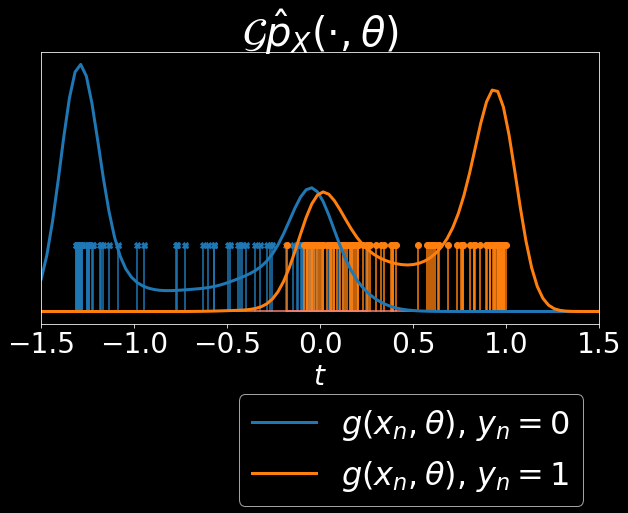

In [14]:
r=50.
plt.figure(figsize=(10,5))
markerline, stemlines, baseline = plt.stem(z1proj[:100],r*np.ones_like(z1proj[:100])/float(N),markerfmt='X',linefmt='#1f77b4')
plt.setp(markerline, 'color', '#1f77b4')
markerline, stemlines, baseline = plt.stem(z2proj[:100],r*np.ones_like(z2proj[:100])/float(N),markerfmt='o',linefmt='#ff7f0e')
plt.setp(markerline, 'color', '#ff7f0e')

t=np.linspace(-1.5,1.5,100)
pz1=np.exp(kz1.score_samples(t[:,np.newaxis]))
pz2=np.exp(kz2.score_samples(t[:,np.newaxis]))


plt.plot(t,pz1,'#1f77b4',linewidth=3)
plt.plot(t,pz2, '#ff7f0e',linewidth=3)

plt.xlim([-1.5,1.5])
# plt.ylim([0,.02])
plt.xticks(fontsize=28)
plt.yticks([])
plt.title(r'$\mathcal{G}\hat{p}_X(\cdot,\theta)$',fontsize=40)
plt.legend([r'$g(x_n,\theta)$, $y_n=0$',r'$g(x_n,\theta)$, $y_n=1$'],
           fontsize=32,bbox_to_anchor=(1.0, -.2))
plt.xlabel(r'$t$',fontsize=28)

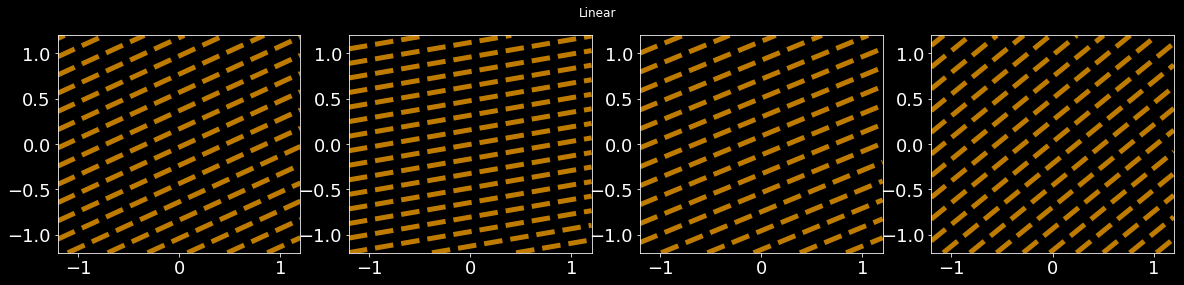

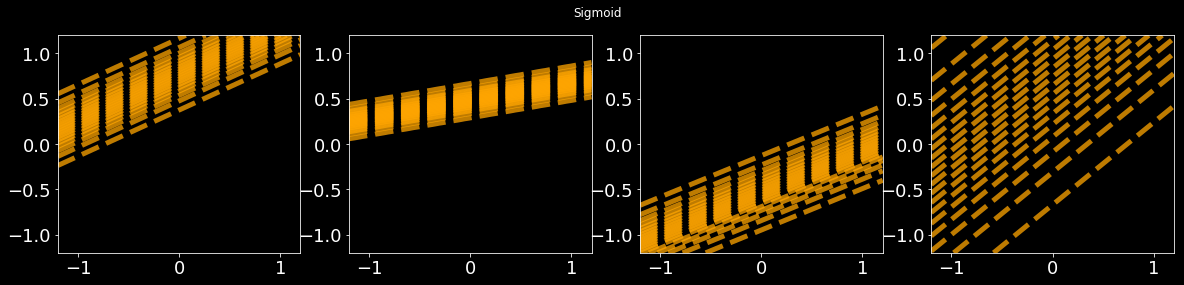

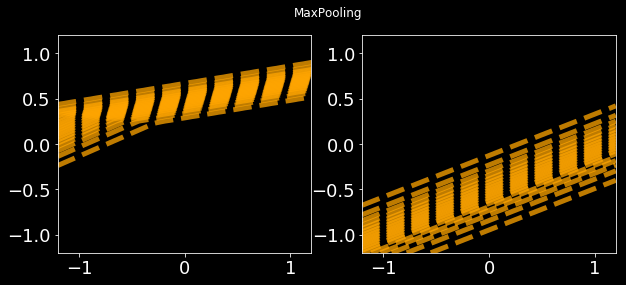

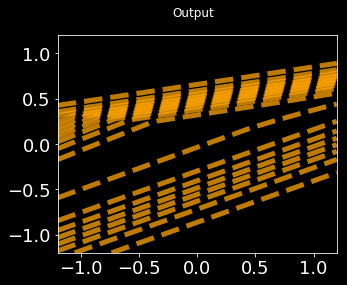

In [34]:
fgridvec=model(torch.from_numpy(gridvec).type(torch.FloatTensor))[:,1].reshape((100,100))

plt.style.use('dark_background')
for layer_idx, title in zip(range(4), ['Linear', 'Sigmoid', 'MaxPooling', 'Output']):
    num_outputs = model.results[layer_idx].shape[1]
    if layer_idx == 3:
        num_outputs = 1
    fig,ax=plt.subplots(1, num_outputs, figsize=(num_outputs * 5, 4))
    if layer_idx == 3:
        ax = [ax]
    for i in range(num_outputs): 
        fgridvec_temp=model.results[layer_idx][:,i].reshape((100,100)).detach().cpu().numpy()
        ax[i].contour(gridx, gridy,
                fgridvec_temp,
                20, colors='orange',linewidths=5,linestyles='--',alpha=.75)
        ax[i].tick_params(axis='x', which='major', labelsize=18)
        ax[i].tick_params(axis='y', which='major', labelsize=18)
    plt.suptitle(title)